# OTMF demonstration notebook

### Imports

In [1]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import matplotlib.image as im
import time
from PIL import Image



from scipy.ndimage import zoom
from scipy.ndimage.filters import gaussian_filter 
from scipy.ndimage.filters import median_filter 

% matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from otmf import parameters
from otmf import gibbs_sampler as gs
from otmf import fields_tools as ft
import otmf.segmentation as sot
from otmf import parameter_estimation as pe

### Misc functions (display, ...)

In [3]:
def plot_directions(angle,pas,taille=1):
    
    S0 = angle.shape[0]
    S1 = angle.shape[1]
    
    y,x = np.ogrid[0:S0,0:S1]
 
    angle2 = angle

    deb_x = np.tile(x,(S0,1)) - taille*np.sin(angle2) 
    deb_y = np.tile(y,(1,S1)) - taille*np.cos(angle2) 
    
    fin_x = np.tile(x,(S0,1)) + taille*np.sin(angle2) 
    fin_y = np.tile(y,(1,S1)) + taille*np.cos(angle2) 
    
    
    for i in range(int(pas/2.),S0,pas):
        for j in range(int(pas/2.),S1,pas):
                plt.plot((deb_x[i,j],fin_x[i,j]), (deb_y[i,j],fin_y[i,j]) ,'k',linewidth=1)
    plt.xlim((-0.5,S1-0.5))
    plt.ylim((-0.5,S0-0.5))     
def plot_taux(im,ref,title):
    
    taux = (im!=ref).mean() * 100
    plt.imshow(im.T,  interpolation='nearest', origin='lower', cmap=plt.cm.bone,); 
    plt.title(title + ' - %.2f'%taux)
    plt.axis('off')
    
def calc_error(A,B):
    return (A[~np.isnan(B)] != B[~np.isnan(B)] ).mean()

### Data loading

In [4]:
def gen_exp(experiment,S0,S1,sig):
    
    print('Experiment '+experiment)

    if experiment=='A': # here v is fixed, and x is a realization of p(X|V=v)
        
        print('Here, v is fixed, and x is a realization of p(X|V=v).')

        dat = np.load('../data/expA.npz')
        X=(dat['X'] > 0)[:S0,:S1]

        V = np.pi/4 * np.ones(shape=(S0,S1))
        V[64:,:] = 3*np.pi/4
        V[:,64:] = (V[:,64:] + np.pi/2)%np.pi
        
    elif experiment=='B':

        dat = np.load('../data/expB.npz')
        X=(dat['X']>0).astype(float)
        V=dat['V']
            
        print('Here, v and x come from a simulation from p(X,V).')

    Y = np.zeros(shape=(S0,S1,1))
    Y[:,:,0] = X + np.random.normal(loc=0.,scale=sig,size=(S0,S1))

    return X[:S0,:S1],V[:S0,:S1],Y[:S0,:S1,:]



##### Here you chose the image to process then load it.

In [5]:

experiment = 'A' # or B


    
S0 = S1 = 100

pas = np.pi/2
v_range = np.arange(pas/2., np.pi, pas)


###################
nb_level_x =1
x_range = np.arange(0, 1+1./nb_level_x, 1./nb_level_x)




pargibbs = parameters.ParamsGibbs(S0 = S0,
                             S1 = S1,
                             v_range = v_range,
                             x_range = x_range
                             )# beta=1.25,


W=1
pargibbs.W = W


SNR = 0
mu = 1
sig = np.linalg.norm(mu)/np.sqrt(pargibbs.W)* 10**(-SNR/20.)

m = 0

rho_1 = 0.5 * sig**2
rho_2 = 0.25 * sig**2


X,V,Y = gen_exp(experiment,S0,S1,sig)






if experiment=='3':

    pargibbs.S0 = S0
    pargibbs.S1 = S1




pargibbs.Y = Y



Experiment A
Here, v is fixed, and x is a realization of p(X|V=v).


### Data display 

Text(0.5,1,u'Observation Y')

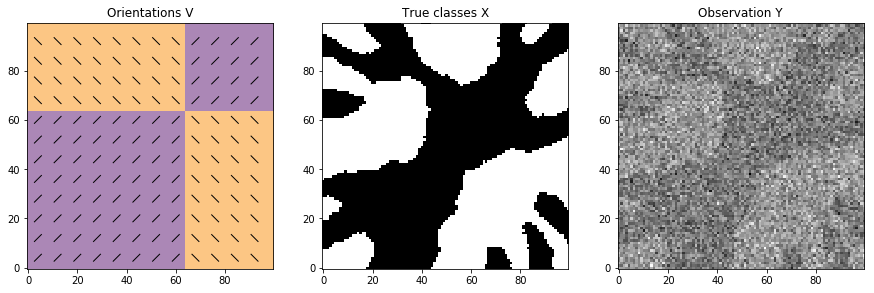

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(131) ; plt.imshow(V,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
plot_directions(V,8,2)
plt.subplot(132) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(133) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')

plt.show()

In [7]:
incert = True 
parseg = parameters.ParamsSeg(nb_iter_sem=40,
                              seuil_conv = 0.05,
                              incert = incert
                                )

parseg.multi = True # le multiclasse discret
parseg.weights=np.ones(shape=(S0,S1))
parseg.mpm = True

parseg.nb_iter_serie_sem = 13
parseg.use_pi = True
parseg.use_alpha = True

#
#==============================================================================
# Segmentation HMF
#==============================================================================
parseg.tmf = False
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) 
print '---------------HMF---------------------'
start = time.time()

Y_courant = np.copy(Y)

pargibbs.Y = Y_courant

X_mpm_hmf,dumb,Ux_hmf,dumb, parsem_hmf = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Time : %.2f s'%end  
print '------------------------------------'
#

---------------HMF---------------------


/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/mpm.py:135: RuntimeWarning: divide by zero encountered in divide
  ratios_x = freqs_mpm_x[:,:,np.newaxis]/freqs_marg_x
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:415: RuntimeWarning: divide by zero encountered in divide
  correc_en = en[np.newaxis,:] / en[:,np.newaxis]
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:415: RuntimeWarning: invalid value encountered in divide
  correc_en = en[np.newaxis,:] / en[:,np.newaxis]
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:419: RuntimeWarning: invalid value encountered in divide
  a = logratios/(facteur) * correc_en
/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/parameter_estimation.py:412: RuntimeWarning: divide by zero encountered in divide
  ratios = pchaps[np.newaxis,:] / pch

Time : 76.27 s
------------------------------------


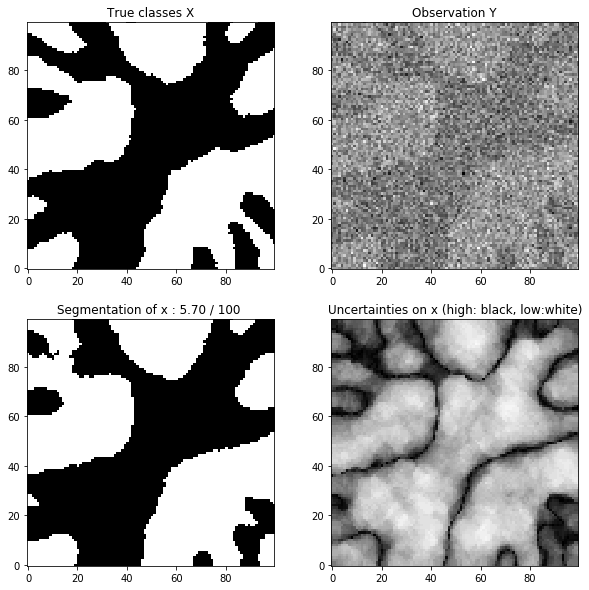

In [12]:
error = calc_error(X,X_mpm_hmf)
error = min(error, 1-error)

plt.figure(figsize=(10,10))

plt.subplot(221) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(222) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')
plt.subplot(223) ; plt.imshow(X_mpm_hmf); plt.title('Segmentation of x : %.2f / 100 '%(100*error))
plt.subplot(224) ; plt.imshow(Ux_hmf,vmin=0,vmax=1); plt.title('Uncertainties on x (high: black, low:white)')
plt.show()

In [9]:
###==============================================================================
### Segmentation OTMF
#####==============================================================================
parseg.tmf = True
pargibbs = parameters.apply_parseg_pargibbs(parseg,pargibbs) # transfetrt a l'autre jeu de parametre
print '---------------OTMF--------------------'
start = time.time()

X_mpm_est,V_mpm_est,Ux_map,Uv_map, parsem = sot.seg_otmf(parseg,pargibbs)

## 
end = time.time() - start
print 'Time : %.2f s'%end  
print '------------------------------------'

---------------OTMF--------------------
Temps total : 367.50 s
------------------------------------


/home/courbot/anaconda2/lib/python2.7/site-packages/otmf-1.0-py2.7.egg/otmf/mpm.py:156: RuntimeWarning: divide by zero encountered in divide
  ratios_v = freqs_mpm_v[:,:,np.newaxis]/freqs_marg_v


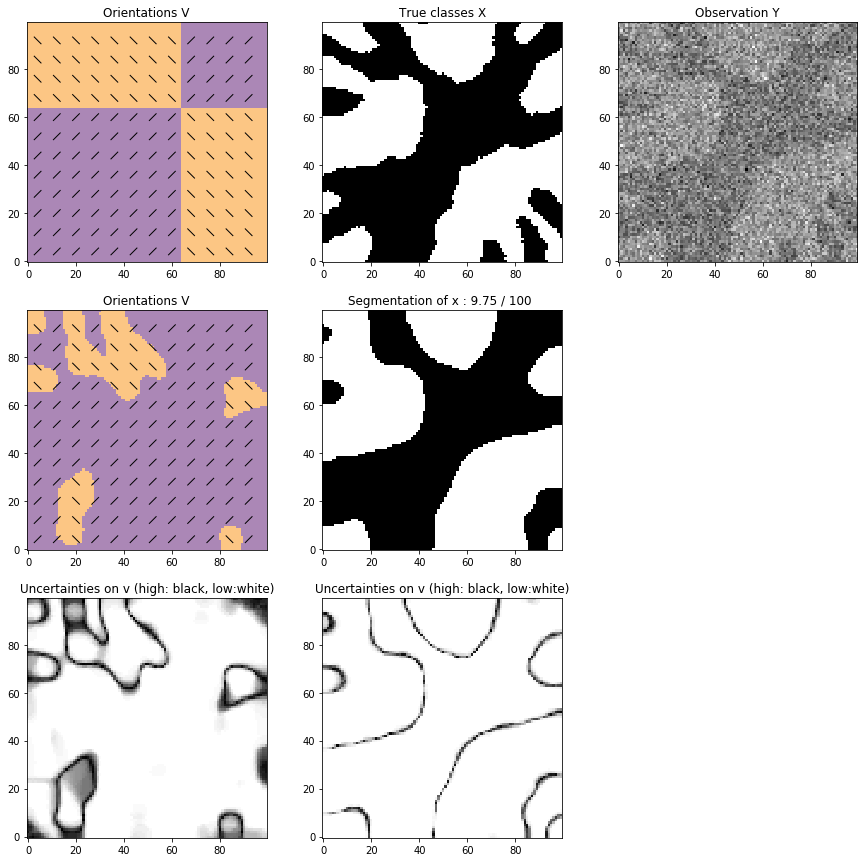

In [17]:
error = calc_error(X,X_mpm_est)
error = min(error, 1-error)

plt.figure(figsize=(15,15))

plt.subplot(331) ; plt.imshow(V,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
plot_directions(V,8,2)
plt.subplot(332) ; plt.imshow(X); plt.title('True classes X')
plt.subplot(333) ; plt.imshow(Y[:,:,0]); plt.title('Observation Y')

plt.subplot(334)
plt.imshow(V_mpm_est,cmap=plt.cm.inferno,vmin=0,vmax=np.pi,alpha=0.5); plt.title('Orientations V')
plot_directions(V_mpm_est,8,2)
plt.subplot(335) ; plt.imshow(X_mpm_est); plt.title('Segmentation of x : %.2f / 100 '%(100*error))

plt.subplot(337); plt.imshow(Uv_map,vmin=0,vmax=1); plt.title('Uncertainties on v (high: black, low:white)')
plt.subplot(338); plt.imshow(Ux_map,vmin=0,vmax=1); plt.title('Uncertainties on v (high: black, low:white)')

plt.show()